# DS-SF-23 | Codealong and Lab 15 | Exploring Rossmann Drug Store Sales Data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

## Codealong - Part A: Data Exploration

In [22]:
df = pd.read_csv(os.path.join('..', 'datasets', 'rossmann.csv'), skipinitialspace = True, low_memory = False)

In [23]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [24]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [25]:
df.Date

0          2015-07-31
1          2015-07-31
2          2015-07-31
3          2015-07-31
4          2015-07-31
              ...    
1017204    2013-01-01
1017205    2013-01-01
1017206    2013-01-01
1017207    2013-01-01
1017208    2013-01-01
Name: Date, dtype: object

In [26]:
df.Date = pd.to_datetime(df.Date)

In [27]:
df.Date

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, dtype: datetime64[ns]

In [28]:
df.set_index('Date', inplace = True)

df['Year'] = df.index.year
df['Month'] = df.index.month

Let's focus on the first store.

In [29]:
df = df[df.Store == 1]

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days.  On state holidays, the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

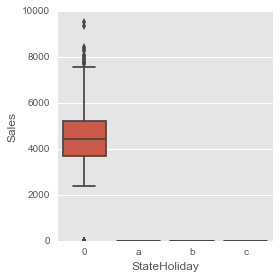

In [30]:
sb.factorplot(x = 'StateHoliday',
    y = 'Sales',
    data = df,
    kind = 'box')

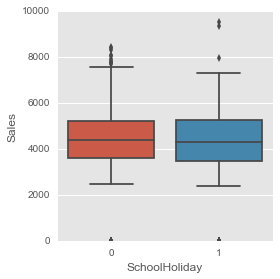

In [31]:
sb.factorplot(x = 'SchoolHoliday',
    y = 'Sales',
    data = df,
    kind = 'box')

> Check: See if there is a difference affecting sales on promotion days.

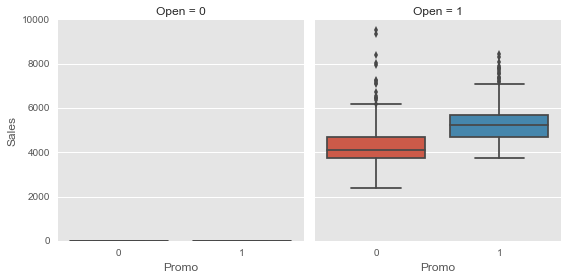

In [53]:
sb.factorplot(col = 'Open',
    x = 'Promo',
    y = 'Sales',
    data = df,
    kind = 'box')

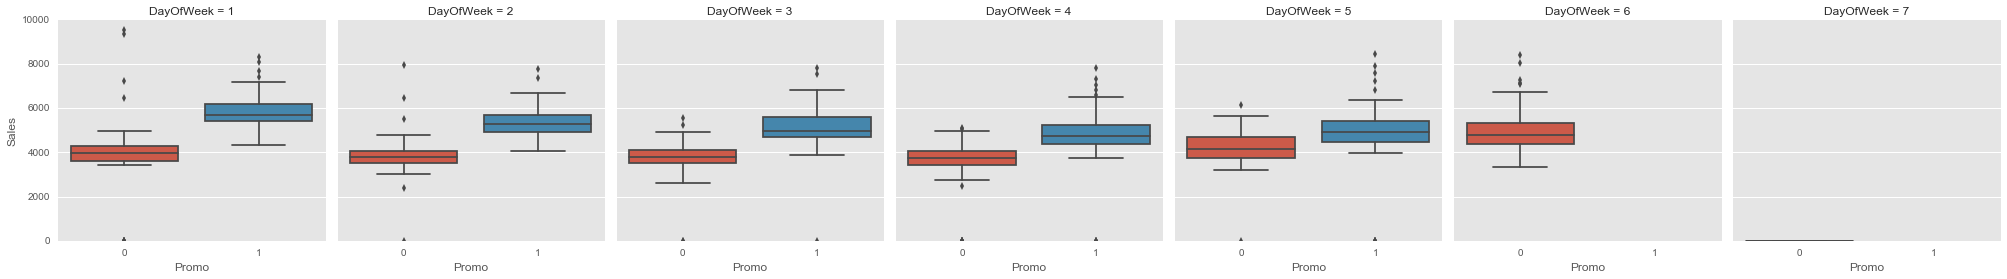

In [55]:
# Check to see if promos are more effective in increasing sales on certain days of the week
# And if promos have been run all days of the week
sb.factorplot(col = 'DayOfWeek',
    x = 'Promo',
    y = 'Sales',
    data = df,
    kind = 'box')

In [45]:
# Find the earliest date in the dataframe
df.sort_index(ascending = True).head(1)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,2013,1


In [46]:
# Find the last date in the dataframe
df.sort_index(ascending = False).head(1)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7


In [48]:
# Find number of non-state holidays with no sales
df[df.StateHoliday =='0'].Sales.value_counts()

0       134
3547      3
3582      3
4663      3
5578      2
       ... 
4756      1
6803      1
6049      1
4752      1
3581      1
Name: Sales, dtype: int64

In [52]:
# Find number of days when store is closed but ther are sales
df[df.Open == 0].Sales.value_counts()

0    161
Name: Sales, dtype: int64

In [51]:
# Find number of each day of week when store is closed
df[df.Open == 0].DayOfWeek.value_counts()

7    134
4     11
5      6
1      6
3      3
2      1
Name: DayOfWeek, dtype: int64

## Codealong - Part B: Seasonality, Trends, and Cycles

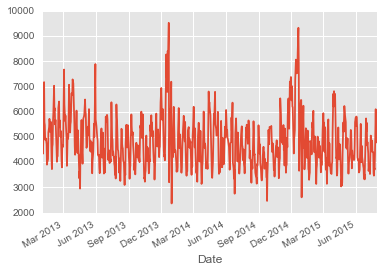

In [56]:
df[df.Open == 1].Sales.plot()

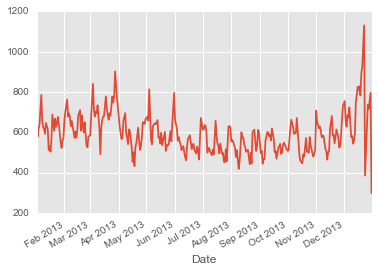

In [57]:
df[(df.Open == 1) & (df.Year == 2013)].Customers.plot()

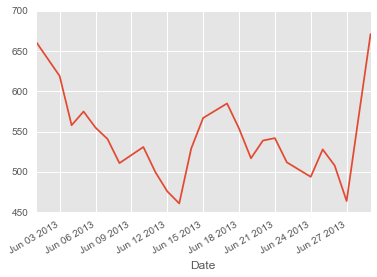

In [58]:
df[(df.Open == 1) & (df.Year == 2013) & (df.Month == 6)].Customers.plot()

## Codealong - Part C: Rolling Averages; `pandas` Window and Expending Functions

In `pandas`, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

### Rolling averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  What were the mean and median sales for each month and year?

In `pandas`, this is performed using the `resample` command, which is very similar to the `groupby` command.  It allows us to group over different time intervals.

We can use `df.resample` and provide as arguments:
- The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
- What aggregation to perform: 'mean', 'median', 'sum', etc.

In [59]:
df.Sales.resample('M', how = ['median', 'mean']).head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  if __name__ == '__main__':


,median,mean
Date,,
2013-01-31,4717.0,4142.935484
2013-02-28,5118.5,4473.964286
2013-03-31,5506.0,4682.870968
2013-04-30,4378.0,3933.633333
2013-05-31,4624.0,3813.709677


While identifying the monthly averages is useful, we often want to compare the sales data of a date to a smaller window.  To understand holidays sales, we don't want to compare late December with the entire month, but perhaps with a few days surrounding it.  We can do this using rolling averages.

In `pandas`, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

In [ ]:
pd.rolling_mean(df.Sales, window = 3, center = True, freq = 'D').head()

`rolling_mean` (as well as `rolling_median`) takes these important parameters:
- the first is the series to aggregate
- `window` is the number of days to include in the average
- `center` is whether the window should be centered on the date or use data prior to that date
- `freq` is on what level to roll-up the averages to (as used in `resample`).  Either `D` for day, `M` for month or `A` for year, etc.

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

In [ ]:
pd.rolling_mean(df.Sales, window = 10, center = True, freq = 'D').plot()

### `pandas` window functions

`pandas` `rolling_mean` and `rolling_median` are only two examples of `pandas` window function capabilities.  Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling_mean` and `rolling_median`, there are `rolling_sum`, `rolling_min`, `rolling_max`... and many more.

Another common one is `diff`, which takes the difference over time.  `pd.diff` takes one arugment, `periods`, which is how many rows prior to use for the difference.

In [ ]:
df.Sales.diff(periods = 1).head()

### `pandas` expanding functions

In addition to the set of `rolling_*` functions, `pandas` also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, use all values up until that time.

In [ ]:
# computes the average sales, from the first date _until_ the date specified.

pd.expanding_mean(df.Sales, freq = 'd').head()

## Codealong - Part D: Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column.  In `pandas`, we do this we with the `autocorr` function:

`autocorr` takes one argument, the `lag` which is how many prio data points should be used to compute the correlation.  If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it.  Setting `lag` to 10 computes the correlation between every point and the point 10 days earlier.

In [ ]:
df.Sales.resample('D', how = 'mean').autocorr(lag = 1)

## Lab

> Question 1.  Plot the distribution of sales by month and compare the effect of promotions

> Question 2.  Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

> Question 3.  Plot the 15 day rolling mean of customers in the stores

> Question 4.  Identify the dates with largest drop in sales from the same date in the previous month

> Question 5.  Compute the total sales up until December 2014

> Question 6.  When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling_mean` and `diff`